In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten

In [2]:
arial_path = '../input/font-recognition-data/Font Dataset Large/Arial'
brandish_path = '../input/font-recognition-data/Font Dataset Large/Brandish'
consolas_path = '../input/font-recognition-data/Font Dataset Large/Consolas'
didot_path = '../input/font-recognition-data/Font Dataset Large/Didot'

In [3]:
arial_filenames = os.listdir(arial_path)
brandish_filenames = os.listdir(brandish_path)
consolas_filenames = os.listdir(consolas_path)
didot_filenames = os.listdir(didot_path)

In [4]:
arial_filenames[:5]

['Image_4378.jpg',
 'Image_747.jpg',
 'Image_561.jpg',
 'Image_345.jpg',
 'Image_3019.jpg']

In [5]:
def load_image(filenames, path):
    images = []
    for filename in tqdm(filenames):
        image = cv2.imread(path+'/'+filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(image)
    
    return images

In [6]:
arial_images = load_image(arial_filenames, arial_path)
brandish_images = load_image(brandish_filenames, brandish_path)
consolas_images = load_image(consolas_filenames, consolas_path)
didot_images = load_image(didot_filenames, didot_path)

100%|██████████| 5000/5000 [00:39<00:00, 125.67it/s]


In [7]:
heights = []
widths = []
for image in arial_images:
    height = image.shape[0]
    width = image.shape[1]
    
    heights.append(height)
    widths.append(width)
    
print('max_h: {}, min_h: {}'.format(max(heights), min(heights)))
print('max_w: {}, min_w: {}'.format(max(widths), min(widths)))

max_h: 32, min_h: 32
max_w: 248, min_w: 30


In [8]:
def take_80_pixels(images_list):
    new_images = []
    for image in images_list:
        if image.shape[1] >= 80:
            new_images.append(image[:,:80])
        else:
            pass
        
    return np.array(new_images)

In [9]:
arial_80 = take_80_pixels(arial_images)
brandish_80 = take_80_pixels(brandish_images)
consolas_80 = take_80_pixels(consolas_images)
didot_80 = take_80_pixels(didot_images)

In [10]:
print(arial_80.shape)
print(brandish_80.shape)
print(consolas_80.shape)
print(didot_80.shape)

(4079, 32, 80)
(4028, 32, 80)
(4741, 32, 80)
(3920, 32, 80)


In [11]:
all_images = np.append(arial_80, brandish_80, axis=0)
all_images = np.append(all_images, consolas_80, axis=0)
all_images = np.append(all_images, didot_80, axis=0)
all_images.shape

(16768, 32, 80)

In [12]:
all_images = all_images.reshape(all_images.shape[0], 
                                all_images.shape[1], 
                                all_images.shape[2], 
                                1)
all_images.shape

(16768, 32, 80, 1)

In [13]:
labels = [0]*len(arial_80) + \
         [1]*len(brandish_80) + \
         [2]*len(consolas_80) + \
         [3]*len(didot_80)

len(labels)

16768

In [14]:
X_train, X_test, y_train, y_test = train_test_split(all_images, 
                                                    labels, 
                                                    test_size=0.3, 
                                                    random_state=88)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [15]:
y_train

array([1, 3, 0, ..., 0, 0, 1])

In [16]:
y_train = y_train[:,np.newaxis]
y_test = y_test[:,np.newaxis]

In [17]:
y_train

array([[1],
       [3],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [18]:
one_hot_encoder = OneHotEncoder(sparse=False)
y_train_encoded = one_hot_encoder.fit_transform(y_train)
y_test_encoded = one_hot_encoder.transform(y_test)

In [19]:
print(y_train[:5])

[[1]
 [3]
 [0]
 [3]
 [3]]


In [20]:
print(y_train_encoded[:5])

[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [21]:
input_shape = (all_images.shape[1], 
               all_images.shape[2], 
               1)

In [22]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', 
                 padding='same', input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 80, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 78, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 39, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 37440)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               3744100   
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2

In [24]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['acc'])

In [25]:
history = model.fit(X_train, y_train_encoded, 
                    epochs=3, 
                    validation_data=(X_test,y_test_encoded))

Epoch 1/3
367/367 [==============================] - 6s 8ms/step - loss: 15.8977 - acc: 0.8829 - val_loss: 0.0939 - val_acc: 0.9932
Epoch 2/3
367/367 [==============================] - 2s 7ms/step - loss: 0.0170 - acc: 0.9974 - val_loss: 0.0118 - val_acc: 0.9988
Epoch 3/3
367/367 [==============================] - 2s 6ms/step - loss: 5.4518e-05 - acc: 1.0000 - val_loss: 0.0106 - val_acc: 0.9992


In [26]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)
predictions

array([1, 3, 3, ..., 1, 1, 2])

In [27]:
y_test = y_test.reshape(y_test.shape[0])
y_test

array([1, 3, 3, ..., 1, 1, 2])

<AxesSubplot:>

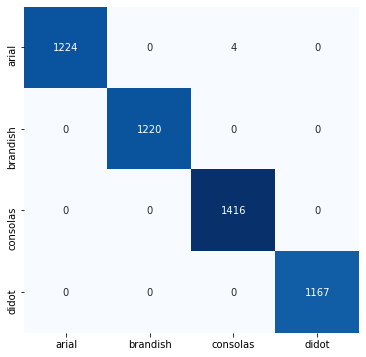

In [28]:
cm = confusion_matrix(y_test, predictions)

label_names = ['arial', 'brandish', 'consolas', 'didot']

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cbar=False,
            xticklabels=label_names, yticklabels=label_names, 
            cmap=plt.cm.Blues)

In [29]:
misses = []
for i in range(len(predictions)):
    if y_test[i] != predictions[i]:
        misses.append(i)
        
print(misses)

[357, 1180, 1553, 3913]


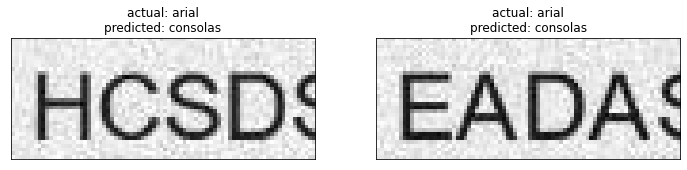

In [30]:
fig, axes = plt.subplots(ncols=2, sharex=False, figsize=(12, 3))

for i, miss in zip(range(2), misses):
    axes[i].set_title('actual: {}\npredicted: {}'
                      .format(str(label_names[y_test[miss]]), 
                              str(label_names[predictions[miss]])))
    axes[i].imshow(X_test[miss], cmap='gray')
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
plt.show()